## Is age and cohort related to divorce?

This notebook is based on cycles of data from the National Survey of Family Growth (NSFG). 

The National Survey of Family Growth (NSFG) gathers information on family life, marriage and divorce, pregnancy, infertility, use of contraception, and men’s and women’s health. The survey results are used by the U.S. Department of Health and Human Services and others to plan health services and health education programs, and to do statistical studies of families, fertility, and health.  

The goal of this project is to identify differences in divorces across cohorts using survival analysis. Also, use Cox regression (or Cox's proportional hazard model) to fit a model with explanatory variables (called covariates) to verify how we can explain variation in divorce rates.

In [1]:
%matplotlib inline
from importlib import reload

import pandas as pd
import numpy as np
import seaborn as sns

import math

import matplotlib.pyplot as plt
from matplotlib import pylab

from scipy.interpolate import interp1d
from scipy.misc import derivative

import thinkstats2
import thinkplot
from thinkstats2 import Cdf

import survival
import marriage

import warnings
warnings.filterwarnings('ignore') #Ignore pandas warnings, too much space on GitHub view
#Try using .loc[row_indexer,col_indexer] = value instead

iters = 21 #number of iterations for EstimateSurvivalByCohort
# iters = 21

### Preparing Data

In [2]:
resp10 = marriage.ReadFemResp2017()
marriage.Validate2017(resp10)

resp9 = marriage.ReadFemResp2015()
marriage.Validate2015(resp9)

resp8 = marriage.ReadFemResp2013()
marriage.Validate2013(resp8)

resp7 = marriage.ReadFemResp2010()
marriage.Validate2010(resp7)

resp6 = marriage.ReadFemResp2002()
marriage.Validate2002(resp6)

married_resps = [resp[resp.evrmarry] for resp in [resp6, resp7, resp8, resp9, resp10]]

First we load the data from different cycles of the NSFG data and gather them in an array of dataframes.

In [3]:
for df in married_resps:
    df['complete'] = df.divorced
    df['complete_var'] = df.mar1diss / 12 # Months the couple stayed together divided by 12.
    df['ongoing_var'] = df.mar1diss / 12
    df['complete_missing'] = df.complete & df.complete_var.isnull()
    df['ongoing_missing'] = ~df.complete & df.ongoing_var.isnull()
    print(sum(df.complete_missing), sum(df.ongoing_missing))
    
    # combine the 90s and 80s cohorts
    # df.loc[df.birth_index==90, 'birth_index'] = 80

0 0
0 0
0 0
0 0
0 0


Then, we prepare the data for a survival analysis, that is a way to describe how long things last. Since we are analysing divorces, our object of study is marriages along a time period. If a marriage has ended, we would say it's ```complete```, else, it's ```ongoing```. So we assign this distinction in the previous cell, addressing the time of the marriage as ```complete_var``` or ```ongoing_var```.

### Distribution analysis
In this part, we take a look at the dataset as a whole, checking for oversampling and other features. We want to determine some summary statistics for the marriages and verify possible errors due to, for example, small sample size or missing data.

In [4]:
df = pd.concat(married_resps, ignore_index=True, sort=False)
len(df)

17095

This is the number of female respondents that have been married at least once.

In [5]:
df.birth_index.value_counts().sort_index()

50     460
60    4417
70    7493
80    4208
90     517
Name: birth_index, dtype: int64

This is the distribution of women per decade. It is possible to see that 50s and 90s women are undersampled and 70s women are oversampled in this dataset.

In [6]:
complete = df.loc[df.complete, 'complete_var']
complete.describe()

count    5135.000000
mean        4.138526
std         4.185355
min         0.000000
25%         0.708333
50%         2.916667
75%         6.166667
max        26.750000
Name: complete_var, dtype: float64

For divorced women, this is the summary of the time spent married. The mean duration of the marriage of divorced women is 4.13 years, but the standard deviation is almost equal, 4.18 years. This means that the data is very widely distributed. 75% of them ended during the first 6.1 years, and the maximum duration for this dataset was 26.75 years.

In [7]:
ongoing = df.loc[~df.complete, 'complete_var']
ongoing.describe()

count    11960.000000
mean         7.169077
std          6.309525
min          0.000000
25%          1.500000
50%          5.750000
75%         11.583333
max         29.000000
Name: complete_var, dtype: float64

For women with marriages that are still going, the mean duration is 7.16 years, with a standard deviation of 6.3 (also means that the data is widely distributed). 75% of them are still going after 11.5 years, which means that most of the marriages durations are below this number. Finally, the maximum duration of an ongoing marriage for this dataset is 29 years.

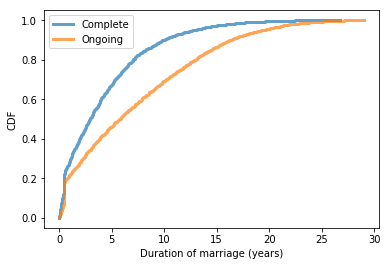

In [8]:
thinkplot.Cdf(thinkstats2.Cdf(complete), label="Complete")
thinkplot.Cdf(thinkstats2.Cdf(ongoing), label="Ongoing")
thinkplot.Config(xlabel='Duration of marriage (years)',
                 ylabel='CDF', legend=True)

In [9]:
thinkstats2.Cdf(complete)[10]

0.9018500486854917

In [10]:
thinkstats2.Cdf(ongoing)[10]

0.6931438127090301

The CDF plot visually describes what was explained before. However, as we can see, there is a considerable difference between ongoing and complete marriages. The duration of marriages that ended are much more shorter than the ones that are still going. In other words, for this dataset, 90.1% of the complete marriages ended in the first 10 years. Moreover, 69.3% of the ongoing marriages have not reached the 10 year "milestone".

### Survival Analysis
In this part, we verify how the rate of divorces are presented in the dataset and observe how long the marriages "survive".

In [11]:
hf = survival.EstimateHazardFunction(complete, ongoing, verbose=False)

In [12]:
hf, sf = marriage.EstimateSurvival(df)

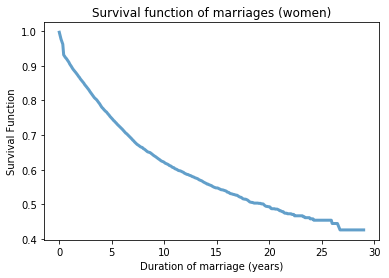

In [13]:
thinkplot.Plot(sf)
thinkplot.Config(title='Survival function of marriages (women)',
                 xlabel='Duration of marriage (years)',
                 ylabel='Survival Function')

The survival function maps from a duration, t, to the probability of surviving longer than t. As we know the distribution of durations of marriages, computing the survival curve is easy, because it is the complement of the CDF.  
Here is the average survival curve regarding all respondents, without distinction of complete or ongoing marriages. With that, we can get a more broad idea of the divorce rate.

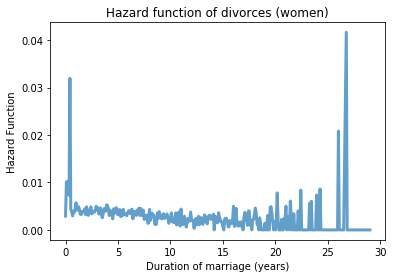

In [14]:
thinkplot.Plot(hf)
thinkplot.Config(title='Hazard function of divorces (women)',
                 xlabel='Duration of marriage (years)',
                 ylabel='Hazard Function')

The hazard function maps from a time, t, to the fraction of marriages that continue until t and then end at t. It is derived from the survival curve and used for Kaplan-Meier estimation.  
Since the lifelines package is used, it is just to show how the hazard function looks.

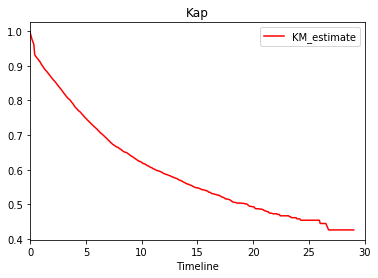

In [15]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()
kmf.fit(df.complete_var, event_observed=df.complete)
kmf.survival_function_.plot(color='red')
thinkplot.Config(xlim=[0, 30],
                title="Kap",
                xlabel="Timeline",
                ylabel="")

The Kaplan-Meier estimator is one of the central algorithms in survival analysis. The data can be used to estimate the hazard function, then convert it to a survival curve. In this case, it is equal to the survival function plotted previously, because our dataset is made of only of respondents that were married at some point. To estimate the hazard function, we consider the women that were divorced at that time (known before as ```complete```) and the number of women "at risk" of getting divorced (known as ```ongoing```).  
The Kaplan-Meier estimator will make more sense later, when we discuss the Cox’s proportional hazard model.

## Divorce by cohort analysis
In this part, we separate the marriages by cohorts, ranging from the 50s to 90s. This will help us analyse how cohort reflects on divorces.

In [16]:
colors = sns.color_palette("colorblind", 5)
cohorts = [80, 70, 60, 50, 90]
colormap = dict(zip(cohorts, colors))

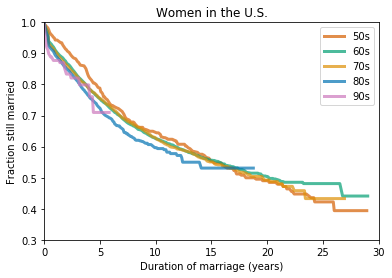

In [17]:
grouped = df.groupby('birth_index')
for name, group in iter(grouped):
    hf, sf = marriage.EstimateSurvival(group)
    thinkplot.Plot(sf, label=str(name)+"s", color=colormap[name])

thinkplot.Config(title='Women in the U.S.',
                 xlabel='Duration of marriage (years)',
                 ylabel='Fraction still married',
                 xlim=[0, 30], ylim=[0.3, 1])

Here we estimate the survival curves for each cohort. As we can see, there are some differences between them and limited curves for the 70s, 80s and 90s, which we will take care of later.  
Initially, we can see that the 80s cohort was more likely to divorce sooner, while the 50s cohort survived more in the first few years then, at the end, had the least fraction still married.

In [18]:
reload(marriage)

# %time sf_map = marriage.EstimateSurvivalByCohort(married_resps, iters=101)
%time sf_map = marriage.EstimateSurvivalByCohort(married_resps, iters=iters)

Wall time: 1.82 s


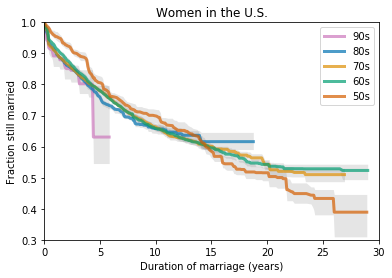

In [19]:
reload(marriage)

marriage.PlotSurvivalFunctions(sf_map, colormap=colormap)

thinkplot.Config(title='Women in the U.S.',
                     xlabel='Duration of marriage (years)',
                     ylabel='Fraction still married',
                     xlim=[0, 30], ylim=[0.3, 1],
                     legend=True, loc='upper right', frameon=True)

The EstimateSurvivalByCohort estimates the survival curves for each cohort with resampled data. That way we can mitigate some of the bias due to under and oversampling. The grey area shows how much variation the data has with different samples.

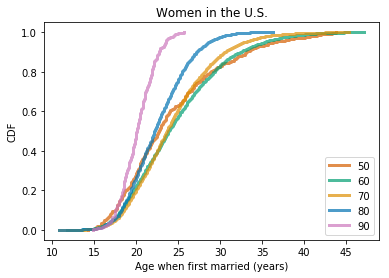

In [20]:
for name, group in iter(grouped):
    cdf = thinkstats2.Cdf(group.agemarry, label=name)
    thinkplot.Cdf(cdf, label=name, color=colormap[name])
    
thinkplot.Config(title='Women in the U.S.',
                     xlabel='Age when first married (years)',
                     ylabel='CDF',
                     legend=True, loc='lower right', frameon=True)

This graph shows the CDFs of age of respondents when first married. As we can see, the 90s women are more likely to have married early than the other cohorts. However, this is a dangerous conclusion, due to the size of the 90s respondents in comparison to other cohorts.  
Women from the 80s also have married earlier than the other cohorts, which can be evidence of why the marriages failed sooner.

In [21]:
reload(marriage)

%time sf_map = marriage.EstimateSurvivalByCohort(married_resps, iters=iters, error_rate=0.1)

Wall time: 7.27 s


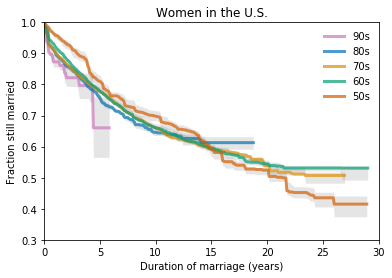

In [22]:
reload(marriage)

marriage.PlotSurvivalFunctions(sf_map, colormap=colormap)

thinkplot.Config(title='Women in the U.S.',
                     xlabel='Duration of marriage (years)',
                     ylabel='Fraction still married',
                     xlim=[0, 30], ylim=[0.3, 1],
                     legend=True, loc='upper right', frameon=False)

This graph uses the EstimateSurvivalByCohort function adding a fixed 1% error rate for each group. It is used to check if the results are vary more than the fixed error, which tells us that there is something wrong with the data. The grey area shows how much variation the data has with different samples. As we can see, the 50s and 90s have a big grey area, which tells us that we have to be careful with these groups. They are both undersampled as we saw earlier with the distribution analysis.

In [23]:
reload(marriage)

%time sf_map = marriage.EstimateSurvivalByCohort(married_resps, iters=iters, predict_flag=True)

Wall time: 1.33 s


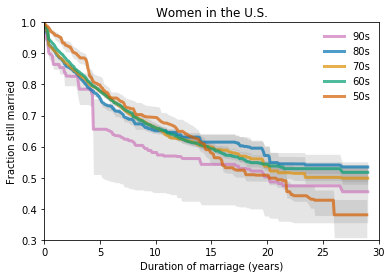

In [24]:
reload(marriage)

marriage.PlotSurvivalFunctions(sf_map, colormap=colormap)

thinkplot.Config(title='Women in the U.S.',
                     xlabel='Duration of marriage (years)',
                     ylabel='Fraction still married',
                     xlim=[0, 30], ylim=[0.3, 1],
                     legend=True, loc='upper right', frameon=False)

Here we try to predict the outcome of the marriages by resampling the data of previous cohorts if needed. Again, a lot of variation for the 90s, which makes us conclude that this data is not reliable for our results.

In [25]:
def MakeTable(sf_map, ages):
    t = []
    for name, sf_seq in sorted(sf_map.items()):
        ts, ss = marriage.MakeSurvivalCI(sf_seq, [50])
        ss = ss[0]
        vals = [np.interp(age, ts, ss, right=np.nan) for age in ages]
        t.append((name, vals))
    return t

In [26]:
def MakePercentageTable(sf_map, ages=[5, 15, 25]):
    t = MakeTable(sf_map, ages)
    for name, sf_seq in sorted(sf_map.items()):
        ts, ss = marriage.MakeSurvivalCI(sf_seq, [50])
        ss = ss[0]
        vals = [np.interp(age, ts, ss, right=np.nan) for age in ages]
        vals = [(val*100) for val in vals]
        print("{0}s | Fraction still married after: ({1} years, {2:.0f}) | ({3} years, {4:.0f}) | ({5} years, {6:.0f})".format(name, 
                                                                                                                    ages[0], vals[0],
                                                                                                                   ages[1], vals[1],
                                                                                                                   ages[2], vals[2]))
        
MakePercentageTable(sf_map)

50s | Fraction still married after: (5 years, 80) | (15 years, 58) | (25 years, 43)
60s | Fraction still married after: (5 years, 78) | (15 years, 59) | (25 years, 53)
70s | Fraction still married after: (5 years, 78) | (15 years, 60) | (25 years, 50)
80s | Fraction still married after: (5 years, 76) | (15 years, 61) | (25 years, 54)
90s | Fraction still married after: (5 years, 66) | (15 years, 54) | (25 years, 47)


The percentage table shows us the fraction of respondents still married after a certain period of time. This helps us visualize the difference between the groups in a more objective way. As we can see, the 50s have the lowest fraction still married after 25 years. Also, the 90s has a low fraction after 5 years in comparison to the others. This has a high chance to be due to undersampling, which makes it hard to conclude things about the two groups.  
On the other hand, the 60s, 70s and 80s curves apparently had a similar behavior, which makes us think that our conclusions towards these groups are more solid.

## Cox’s proportional hazard model

Cox regression (or proportional hazards model) is a method for investigating the effect of several variables upon the time a specified event takes to happen. It is very similar to a regression model, but for survival analysis.

The documentation for the library used to implement this model can be seen here: https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html

In [27]:
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter

In [28]:
relevant_columns = ['birth_index', 'agemarry', 'age', 'complete_var', 'complete']
df1 = df[relevant_columns]

print(len(df1))
print(len(df1.dropna()))

17095
17014


Because of some missing values for ```agemarry```, the CoxPHFitter would crash. Since there aren't many missing values, we just drop them.  
First, we want to check how ```birth_index```, `agemarry`, and ```age``` reflect on the survival curve. 

- ```birth_index``` represents the cohort of the respondent.
- ```agemarry``` represents the age of the respondent when first married.
- ```age``` represents the age of the respondent at the moment of the survey.

After fitting, we need to know how "good" of a fit the model was to the data. For that, we can do two methods:
- Looking at the concordance-index.
- Compare spread between baseline survival function vs Kaplan Meier estimator

The concordance-index evaluates the accuracy of the ordering of predicted time. 0.5 is the expected result from random predictions, 1.0 is perfect concordance and, 0.0 is perfect anti-concordance.
Fitted survival models typically have a concordance index between 0.55 and 0.75 (this may seem bad, but even a perfect model has a lot of noise than can make a high score impossible).

The spread can be interpreted as how much "variance" is provided by the baseline hazard vs the partial hazard. If none of the variance is explained by the covariates (similar to explanatory variables), the baseline hazard is approximately equal to the Kaplan-Meier estimator. Deviations from this provide a visual measure of variance explained.

In [29]:
cph = CoxPHFitter()
cph.fit(df1.dropna(), duration_col='complete_var', event_col='complete', show_progress=True)
cph.print_summary()

Iteration 1: norm_delta = 0.90596, step_size = 0.9500, ll = -46389.58048, newton_decrement = 720.98669, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.05243, step_size = 0.9500, ll = -45681.77447, newton_decrement = 7.16464, seconds_since_start = 0.1
Iteration 3: norm_delta = 0.00304, step_size = 0.9500, ll = -45674.62194, newton_decrement = 0.02016, seconds_since_start = 0.1
Iteration 4: norm_delta = 0.00015, step_size = 1.0000, ll = -45674.60182, newton_decrement = 0.00005, seconds_since_start = 0.1
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, ll = -45674.60177, newton_decrement = 0.00000, seconds_since_start = 0.1
Convergence completed after 5 iterations.
<lifelines.CoxPHFitter: fitted with 17014 observations, 11912 censored>
      duration col = 'complete_var'
         event col = 'complete'
number of subjects = 17014
  number of events = 5102
    log-likelihood = -45674.60
  time fit was run = 2019-04-08 07:31:21 UTC

---
             coef exp(coef)  se(coef)     

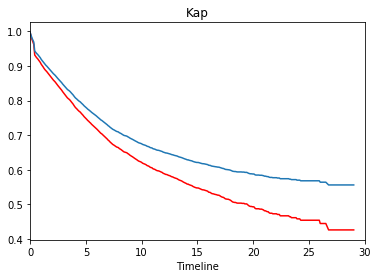

In [30]:
kmf = KaplanMeierFitter()
kmf.fit(df.complete_var, event_observed=df.complete)

plt.plot(kmf.survival_function_, color='red')
plt.plot(cph.baseline_survival_)
thinkplot.Config(xlim=[0, 30],
                title="Kap",
                xlabel="Timeline",
                ylabel="")

As we can see from the spread and 0.66 concordance, our model has a good fit using all three variables. This means that these variables have a big impact on divorces. To see how much they affect the model, we need to look at their coefficients, listed as "coefs" in the summary function. A higher hazard means more at risk of the event occurring. 

- ```birth_index``` has a coefficient of 0.04. This means that, a one unit increase in ```birth_index``` means the the baseline hazard will increase by a factor of exp(0.04)=1.04 - about a 4% increase.
- ```agemarry``` has a coefficient of -0.12. This gives exp(-0.12)=0.89 - about a 11% decrease.
- ```age``` has a coefficient of 0.09. This gives exp(0.09)=1.09 - about a 9% increase.

With that, we can conclude that ```birth_index``` and ```age``` can increase the chance of a divorce, while ```agemarry``` decreases it.
Next, it is interesting to check how much the individual variables affect the model.

In [31]:
relevant_columns = ['age', 'complete_var', 'complete']
df1 = df[relevant_columns]

cph = CoxPHFitter()
cph.fit(df1.dropna(), duration_col='complete_var', event_col='complete', show_progress=True)
cph.print_summary()

Iteration 1: norm_delta = 0.17001, step_size = 0.9500, ll = -46713.40461, newton_decrement = 52.04838, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.01236, step_size = 0.9500, ll = -46660.86131, newton_decrement = 0.26331, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.00064, step_size = 0.9500, ll = -46660.59835, newton_decrement = 0.00071, seconds_since_start = 0.1
Iteration 4: norm_delta = 0.00003, step_size = 1.0000, ll = -46660.59765, newton_decrement = 0.00000, seconds_since_start = 0.1
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, ll = -46660.59764, newton_decrement = 0.00000, seconds_since_start = 0.1
Convergence completed after 5 iterations.
<lifelines.CoxPHFitter: fitted with 17095 observations, 11960 censored>
      duration col = 'complete_var'
         event col = 'complete'
number of subjects = 17095
  number of events = 5135
    log-likelihood = -46660.60
  time fit was run = 2019-04-08 07:31:22 UTC

---
     coef exp(coef)  se(coef)     z      p 

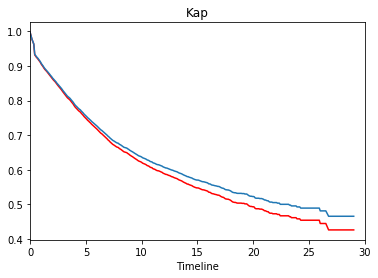

In [32]:
kmf = KaplanMeierFitter()
kmf.fit(df.complete_var, event_observed=df.complete)

plt.plot(kmf.survival_function_, color='red')
plt.plot(cph.baseline_survival_)
thinkplot.Config(xlim=[0, 30],
                title="Kap",
                xlabel="Timeline",
                ylabel="")

By using only the ```age``` variable for the Cox regression, we can see that it is a variable with 0.55 concordance and some spread from the Kaplan-Meier function. It has a coefficient of 0.03. This gives exp(0.03)=1.03 - about a 3% increase.  

In [33]:
relevant_columns = ['agemarry', 'complete_var', 'complete']
df1 = df[relevant_columns]

cph = CoxPHFitter()
cph.fit(df1.dropna(), duration_col='complete_var', event_col='complete', show_progress=True)
cph.print_summary()

Iteration 1: norm_delta = 0.42507, step_size = 0.9500, ll = -46389.58048, newton_decrement = 384.27112, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.08026, step_size = 0.9500, ll = -45981.26804, newton_decrement = 10.92477, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.00580, step_size = 0.9500, ll = -45970.23627, newton_decrement = 0.05469, seconds_since_start = 0.1
Iteration 4: norm_delta = 0.00030, step_size = 1.0000, ll = -45970.18167, newton_decrement = 0.00014, seconds_since_start = 0.1
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, ll = -45970.18152, newton_decrement = 0.00000, seconds_since_start = 0.1
Convergence completed after 5 iterations.
<lifelines.CoxPHFitter: fitted with 17014 observations, 11912 censored>
      duration col = 'complete_var'
         event col = 'complete'
number of subjects = 17014
  number of events = 5102
    log-likelihood = -45970.18
  time fit was run = 2019-04-08 07:31:22 UTC

---
          coef exp(coef)  se(coef)      z

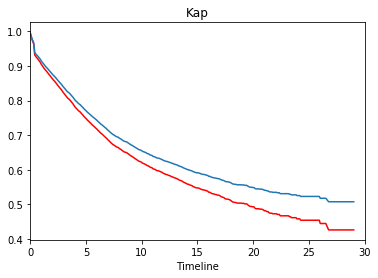

In [34]:
kmf = KaplanMeierFitter()
kmf.fit(df.complete_var, event_observed=df.complete)

plt.plot(kmf.survival_function_, color='red')
plt.plot(cph.baseline_survival_)
thinkplot.Config(xlim=[0, 30],
                title="Kap",
                xlabel="Timeline",
                ylabel="")

By using only the ```agemarry``` variable for the Cox regression, we can see that it is a variable with 0.63 concordance and a higher spread from the Kaplan-Meier function than ```age```. It has a coefficient of -0.10. This gives exp(-0.10)=0.9 - about a 10% decrease.  

In [35]:
relevant_columns = ['birth_index', 'complete_var', 'complete']
df1 = df[relevant_columns]

cph = CoxPHFitter()
cph.fit(df1.dropna(), duration_col='complete_var', event_col='complete', show_progress=True)
cph.print_summary()

Iteration 1: norm_delta = 0.05163, step_size = 0.9500, ll = -46713.40461, newton_decrement = 5.56370, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.00259, step_size = 0.9500, ll = -46707.85442, newton_decrement = 0.01399, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.00013, step_size = 0.9500, ll = -46707.84046, newton_decrement = 0.00004, seconds_since_start = 0.1
Iteration 4: norm_delta = 0.00001, step_size = 1.0000, ll = -46707.84042, newton_decrement = 0.00000, seconds_since_start = 0.1
Convergence completed after 4 iterations.
<lifelines.CoxPHFitter: fitted with 17095 observations, 11960 censored>
      duration col = 'complete_var'
         event col = 'complete'
number of subjects = 17095
  number of events = 5135
    log-likelihood = -46707.84
  time fit was run = 2019-04-08 07:31:23 UTC

---
             coef exp(coef)  se(coef)    z      p  -log2(p)  lower 0.95  upper 0.95
birth_index  0.01      1.01      0.00 3.34 <0.005     10.20        0.00        0.01
---


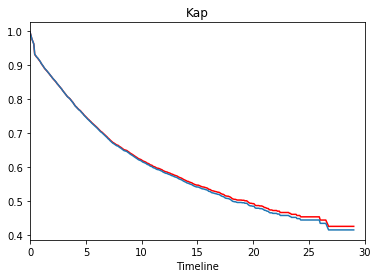

In [36]:
kmf = KaplanMeierFitter()
kmf.fit(df.complete_var, event_observed=df.complete)

plt.plot(kmf.survival_function_, color='red')
plt.plot(cph.baseline_survival_)
thinkplot.Config(xlim=[0, 30],
                title="Kap",
                xlabel="Timeline",
                ylabel="")

By using only the ```birth_index``` variable for the Cox regression, we can see that it is a variable with 0.52 concordance and the baseline hazard is approximately equal to the Kaplan-Meier function. This means that the variance isn't explained by the covariate. It has a coefficient of 0.01. This gives exp(0.01)=1.01 - about a 1% increase.

With that, we can conclude that ```agemarry``` and ```age``` have a big impact in divorce rate. The more aged the woman is when first married the better, because it reduces the hazard of divorce by 10% per year for the model given. However, the more aged the woman is, the worse, because this variable increases the hazard of divorce by 3% per year.